# logp evaluation of PAE

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [8]:
10e3

10000.0

In [ ]:
((1e3+10e3)/300*70)/60

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


In [5]:
from ray.util.multiprocessing import Pool as RayPool
import bayesfast as bf
bf.utils.parallel.set_backend(RayPool(4))
bf.utils.random.set_generator(4)
den = bf.DensityLite(logp=lambda x: -0.5 * x @ x, grad=lambda x: -x,
                     input_size=4)
foo = bf.sample(den)
foo

2021-01-07 16:16:28,428	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=4090)  CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 0.37 seconds. (warmup)
(pid=4088)  CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 0.67 seconds. (warmup)
(pid=4090)  CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 0.23 seconds.
(pid=4087)  CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 0.71 seconds. (warmup)
(pid=4090)  CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 0.20 seconds.
(pid=4089)  CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 0.72 seconds. (warmup)
(pid=4090)  CHAIN #3 : sampling proceeding [ 1200 / 1500 ], last 300 samples used 0.20 seconds.
(pid=4088)  CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 0.65 seconds.
(pid=4090)  CHAIN #3 : sampling finished [ 1500 / 1500 ], obtained 1500 samples in 1.26 seconds.
(pid=4087)  CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 0.68 seconds.
(pid=4089) 

(pid=4087)  CHAIN #2 : sampling finished [ 1500 / 1500 ], obtained 1500 samples in 2.49 seconds.


### Loading the trained modules and evaluating logp in tensorflow

In [6]:
from pae.model_tf2 import get_prior, get_posterior

In [7]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [3]:
import os, pickle
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file  = 'params_mnist_-1_10_vae10_AE_test_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [4]:
params

{'logtostderr': False,
 'alsologtostderr': False,
 'log_dir': '',
 'v': -1,
 'verbosity': -1,
 'stderrthreshold': 'fatal',
 'showprefixforinfo': True,
 'tfhub_cache_dir': None,
 'model_dir': '/global/scratch/vboehm/rnf/models/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma',
 'data_set': 'mnist',
 'module_dir': '/global/cscratch1/sd/vboehm/RNF/modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma',
 'data_dir': '/global/cscratch1/sd/vboehm/RNF/datasets',
 'celeba_dim': 64,
 'learning_rate': 0.0001,
 'batch_size': 16,
 'max_steps': 500000,
 'n_steps': 5000,
 'loss': 'AE',
 'output_images': True,
 'full_sigma': array([1.21699713e-07, 7.09743763e-04, 1.02994021e-03, 1.02151698e-03,
        1.03679986e-03, 1.04475720e-03, 1.02805020e-03, 1.00746250e-03,
        1.01832906e-03, 9.80183366e-04, 1.08048529e-03, 1.05271244e-03,
        1.02726626e-03, 1.17903226e-03, 1.40199822e-03, 9.60169651e-04,
        9.90029890e-04, 1.04802335e-03, 9.90563538e-04, 

In [9]:
# params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
# params['data_dir']= '../../data/'

In [10]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=True)

if np.all(x_test)==None:
    x_test=x_valid

x_train = x_train/256.-0.5
x_test  = x_test/256.-0.5
x_valid = x_valid/256.-0.5

In [11]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid8_nepoch220')

In [12]:
def get_likelihood(decoder,sigma):
    
  
    def likelihood(z):
        mean = decoder({'z':z})['x']
        return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma))

    return likelihood

In [13]:
z_fill        = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32))

sigma         = params['full_sigma']
sigma         = tf.cast(sigma,tf.float32)

encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)

likelihood    = get_likelihood(decoder,sigma)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
def get_encoded(x):
    return encoder({'x':x})['z']

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood    = likelihood(z).log_prob(x)
    return likelihood

def prior_eval(z,nvp_funcs=nvp_funcs):
    prior         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']
    return prior

def posterior_eval(z,x,likelihood, nvp_funcs):
    likelihood   = likelihood_eval(z,x,likelihood)
    prior        = get_prior(params['latent_size'])
    prior        = prior_eval(z, nvp_funcs)
    logprob      = likelihood+prior
    return logprob

def logp(z,x=x_valid[0:16], negative=False):

    z_fill[0].assign(z)
    z_  = tf.convert_to_tensor(z_fill)
    
    log_p         = posterior_eval(z_,x,likelihood,nvp_funcs)
    if negative:
        log_p = -log_p

    return log_p[0]

def logp_grad(z,x=x_valid[0:16], negative=False):
    

    sigma         = params['full_sigma']
    sigma         = tf.cast(sigma,tf.float32)
    
    z_fill[0].assign(z)
    z_  = tf.convert_to_tensor(z_fill)
    with tf.GradientTape() as tape:
        tape.watch(z_)
        log_p         = posterior_eval(z_,x,likelihood,nvp_funcs)
        if negative:
            log_p = -log_p
    grads = tape.gradient(log_p, [z_])
    return grads[0]

### Minimize -logp, starting from encoded value

In [15]:
z_ini = get_encoded(x_valid[0:16])[:,:10]

In [17]:
logp(z_ini[0],negative=False)

<tf.Tensor: shape=(), dtype=float32, numpy=1763.1522>

In [16]:
logp_grad(z_ini[0],negative=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(16, 10), dtype=float32, numpy=
array([[ 7.84890137e+01,  7.77921982e+01,  5.30694885e+01,
        -6.32094345e+01, -4.05722160e+01, -2.25107384e+01,
         1.20050163e+01, -4.65365410e+00, -4.44403038e+01,
         2.75073318e+01],
       [-7.59744415e+01, -1.10177132e+02, -2.94932983e+02,
        -2.99275208e+01,  2.24224548e+02, -3.34789001e+02,
         1.09502335e+02,  2.23677155e+02,  2.08214371e+02,
        -1.77685120e+02],
       [-6.87870102e+01, -8.15668716e+01,  3.97228668e+02,
        -2.63767914e+02,  9.93178177e+01, -1.31778145e+01,
        -3.24331024e+02, -3.29805145e+01, -2.09026505e+02,
         4.19897690e+01],
       [-3.61163378e-01, -1.93864655e+02, -2.99768677e+02,
         2.93321190e+01,  1.22860413e+02, -3.25910339e+02,
         7.01234665e+01, -1.93872681e+02, -2.25574493e+02,
        -8.09570694e+01],
       [-2.13618908e+01, -1.96118530e+02,  2.71945465e+02,
        -1.40682205e+02, -1.40804718e+02,  9.46836472e+01,
        -1.37891129e

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
z_var     = tf.Variable(z_ini[0])
losses    = []
z         = z_ini[0]
for iteration in tqdm(range(300)):
    grads = logp_grad(z,negative=True)
    loss  = logp(z,negative=True)
    optimizer.apply_gradients(zip(grads, [z_var]))
    z           = tf.convert_to_tensor(z_var)
    losses.append(loss)

  0%|          | 0/300 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 300/300 [00:40<00:00,  7.40it/s]


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


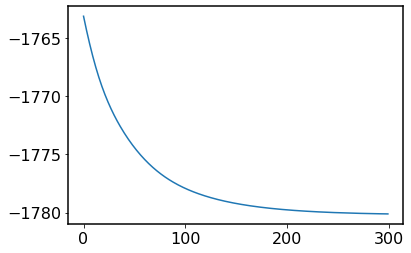

In [21]:
losses = np.asarray(losses)
plt.plot(losses)

In [22]:
def build_container(z):
    filler = np.zeros((params['batch_size'],len(z)))
    filler[0] = z
    return filler

In [23]:
x_esti = np.reshape(get_decoded(build_container(z))[0], (28,28))
x_ini  = np.reshape(get_decoded(z_ini)[0], (28,28))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



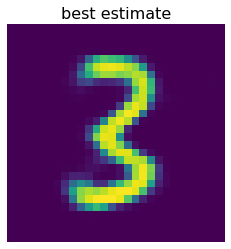

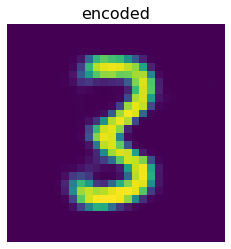

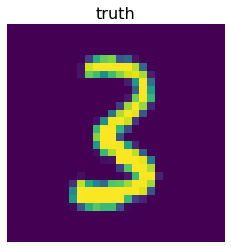

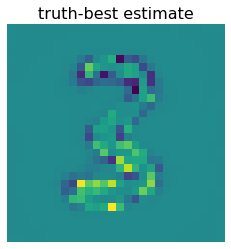

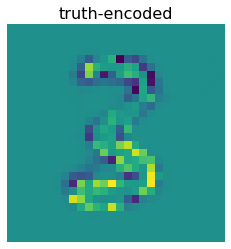

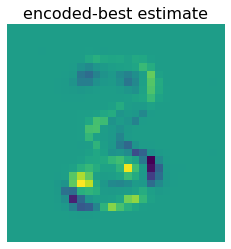

In [24]:
plt.title('best estimate')
plt.imshow(np.reshape(x_esti, (28,28)))
plt.axis('off')
plt.show()
plt.title('encoded')
plt.imshow(np.reshape(x_ini,(28,28)))
plt.axis('off')
plt.show()
plt.title('truth')
plt.imshow(x_valid[0].reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth-best estimate')
plt.imshow(x_valid[0].reshape(28,28)-x_esti.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth-encoded')
plt.imshow(x_valid[0].reshape(28,28)-x_ini.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('encoded-best estimate')
plt.imshow(x_ini.reshape(28,28)-x_esti.reshape(28,28))
plt.axis('off')
plt.show()

In [158]:
import bayesfast as bf

In [25]:
den = bf.DensityLite(logp=logp, grad=logp_grad, input_size=10, hard_bounds=False)

In [170]:
logp(z_ini[0])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(), dtype=float32, numpy=1763.1522>

In [171]:
import multiprocess
with multiprocess.Pool(4) as pool:
    foo = pool.map(logp, [z_ini[0], z_ini[0],z_ini[0], z_ini[0]])

KeyboardInterrupt: 

In [27]:
sampling_params = dict(n_chain=1, n_iter=100, n_warmup=10, x_0=z_ini[0],
                 random_generator=None, step_size=1e-6, adapt_step_size=False,
                 metric='diag', adapt_metric=False, max_change=1000.,
                 target_accept=0.6, gamma=0.05, k=0.75, t_0=10.,
                 initial_mean=None, initial_weight=1., adapt_window=60,
                 update_window=1, doubling=True)

In [28]:
res = bf.sample(den, sample_trace=sampling_params)

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: perm_swap0:0